## Google Stock Price
*Виконала Сачек Владислава КА-31*
- Розглянуа задача регресії полягає у прогнозі ціни відкриття акції Open наступного дня на основі ціни Open поточного дня. Модель - **гребнева регресiя** з рiзними значеннями гiперпараметру alpha, використовуючи sklearn.linear_model.Ridge.

#### Імпорт бібліотек і завантаження даних

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

train_df['Open'] = pd.to_numeric(train_df['Open'], errors='coerce')
test_df['Open'] = pd.to_numeric(test_df['Open'], errors='coerce')
train_df.dropna(inplace=True)

#### Візуалізація початкових даних

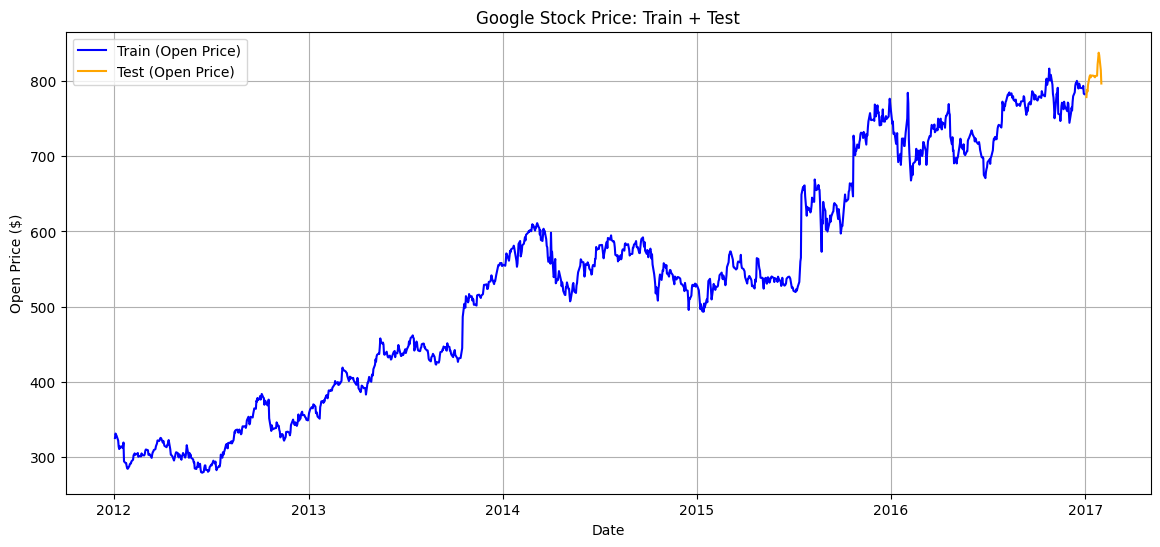

In [2]:
plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['Open'], label='Train (Open Price)', color='blue')
plt.plot(test_df['Date'], test_df['Open'], label='Test (Open Price)', color='orange')
plt.title("Google Stock Price: Train + Test")
plt.xlabel("Date")
plt.ylabel("Open Price ($)")
plt.legend()
plt.grid(True)
plt.show()

#### Розбиття початкових даних на навчальний і валідаційний набори

In [3]:
X = train_df[['Open']].values[:-1]
y = train_df['Open'].values[1:]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Розмір навчального набору: {len(X_train)}")
print(f"Розмір валідаційного набору: {len(X_val)}")


Розмір навчального набору: 1005
Розмір валідаційного набору: 252


#### Графічне представлення відношення Open(day t) і Open(day t+1) на повному наборі даних

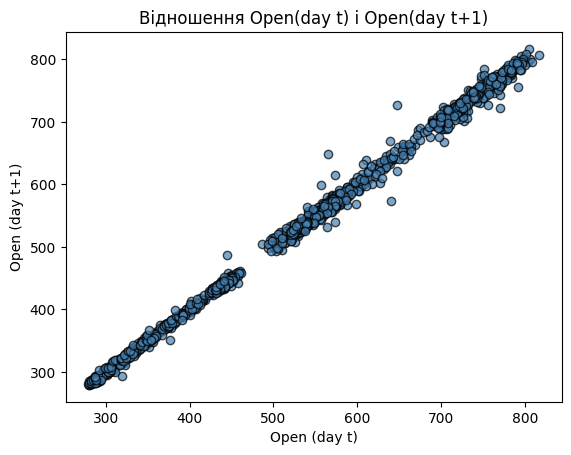

In [4]:
plt.scatter(X, y, alpha=0.7, color="steelblue", edgecolor="k")
plt.xlabel("Open (day t)")
plt.ylabel("Open (day t+1)")
plt.title("Відношення Open(day t) і Open(day t+1)")
plt.show()

Майже всі точки лежать на діагоналі, тому лінійна регресія має достатньо точно прогнозувати дані.

#### Масштабування

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#### Побудова моделі для різних значень гіперпараметру alpha  
Візьмемо 8 значень коефцієнта регуляризації alpha від 0.001 до 100, навчимо моделі гребневої регресії і виконаємо прогнози значень з використанням методів *fit()* та *predict()* з sklearn.linear_model.Ridge. Обчислимо для кожної моделі критерії якості $ R^2, RMSE, MAE, MAPE $ на обох наборах даних:

In [6]:

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

alphas = [1e-3, 1e-2, 1, 3, 5, 10, 20, 100]
results = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    
    y_train_pred = ridge.predict(X_train_scaled)
    y_val_pred = ridge.predict(X_val_scaled)
    
    metrics = {
        "alpha": alpha,
        "R2_train": r2_score(y_train, y_train_pred),
        "R2_val": r2_score(y_val, y_val_pred),
        "RMSE_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "RMSE_val": np.sqrt(mean_squared_error(y_val, y_val_pred)),
        "MAE_train": mean_absolute_error(y_train, y_train_pred),
        "MAE_val": mean_absolute_error(y_val, y_val_pred),
        "MAPE_train": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "MAPE_val": np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100
    }
    results.append(metrics)

#### Оцінка якості моделей з різними alpha

In [7]:
res_df = pd.DataFrame(results)
print(res_df)

     alpha  R2_train    R2_val  RMSE_train   RMSE_val  MAE_train    MAE_val  \
0    0.001  0.995646  0.919600    8.001077   9.857010   4.989104   7.150068   
1    0.010  0.995646  0.919602    8.001077   9.856886   4.989074   7.150024   
2    1.000  0.995645  0.919767    8.001981   9.846796   4.988986   7.147590   
3    3.000  0.995637  0.919756    8.009176   9.847443   4.995437   7.166888   
4    5.000  0.995622  0.919291    8.023465   9.875920   5.010278   7.220813   
5   10.000  0.995549  0.916177    8.089386  10.064639   5.073452   7.517376   
6   20.000  0.995267  0.901860    8.342099  10.890311   5.362306   8.631828   
7  100.000  0.987492  0.463733   13.561228  25.457040  10.595206  23.891681   

   MAPE_train  MAPE_val  
0    1.029395  0.970608  
1    1.029390  0.970601  
2    1.029608  0.970174  
3    1.031856  0.972536  
4    1.036350  0.979512  
5    1.053733  1.018489  
6    1.130085  1.165369  
7    2.421837  3.194041  


In [8]:
best_alpha = res_df.loc[res_df["RMSE_val"].idxmin(), "alpha"]
print(f"\nalpha with the lowest RMSE_val: {best_alpha}")


alpha with the lowest RMSE_val: 1.0


> Найкращий баланс між точністю на навчальних і тестових даних спостерігається для alpha = 1.0:
> - $R^2$ = 0.9198, тобто модель пояснює ~92% варіації ціни відкриття
> - середньоквадратична похибка RMSE = 9.8468$
> - середня абсолютна похибка MAE = 7.1476$
> - MAPE = 0.97%, тобто середнє відсоткове значення помилок менше 1%, модель точна. 

> Різниця помилок на навчальних і тесових даних мала, тобто **перенавчання немає**. На великих значеннях alpha (100) дещо погіршуються значення критеріїв якості на навчальному наборі, а на тестовому - значно погіршуються, тобто виникає недонавчання.

#### Графічне представлення ліній гребневої регресії з різними alpha

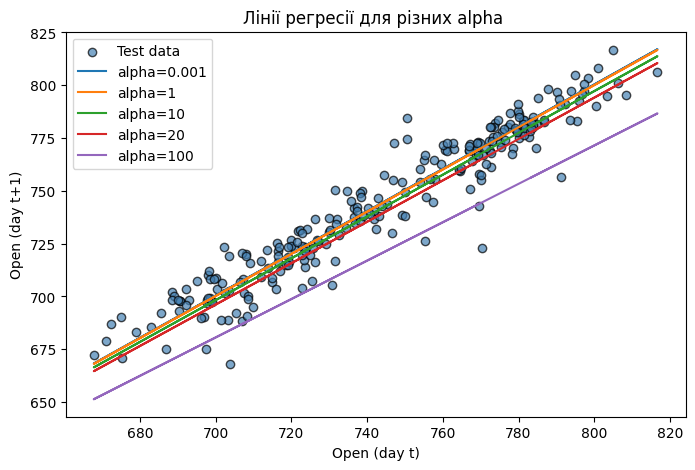

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(X_val, y_val, alpha=0.7, color="steelblue", edgecolor="k", label='Test data')

for alpha in [0.001, 1, 10, 20, 100]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred = ridge.predict(X_val_scaled)
    plt.plot(X_val, y_pred, label=f"alpha={alpha}")

plt.title("Лінії регресії для різних alpha ")
plt.xlabel("Open (day t)")
plt.ylabel("Open (day t+1)")
plt.legend()
plt.show()

#### Решітчастий пошук для підбору гіперпараметру alpha

In [10]:
param_grid = {"alpha": np.logspace(-3, 2, 10)}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train_scaled, y_train)

print("\nGridSearchCV best alpha:", grid.best_params_["alpha"])
best_alpha_grid = grid.best_params_["alpha"]


GridSearchCV best alpha: 0.001


Отримано alpha дуже близьке до нуля, тобто модель, близька до звичайної лінійної регресії, може бути найкращою.

Метрики для моделі з alpha за GridSearchCV:

In [11]:
best_ridge = Ridge(alpha=best_alpha_grid)
best_ridge.fit(X_train_scaled, y_train)
y_pred_grid = best_ridge.predict(X_val_scaled)

print("R2_val:", r2_score(y_val, y_pred_grid))
print("RMSE_val:", np.sqrt(mean_squared_error(y_val, y_pred_grid)))
print("MAE_val:", mean_absolute_error(y_val, y_pred_grid))
print("MAPE_val:", np.mean(np.abs((y_val - y_pred_grid) / y_val)) * 100, "%")

R2_val: 0.9196000337615848
RMSE_val: 9.85700994329222
MAE_val: 7.150068430245963
MAPE_val: 0.9706077178350829 %


#### Оцінка впливу розміру навчальної множини на якість моделі за кривою навчання

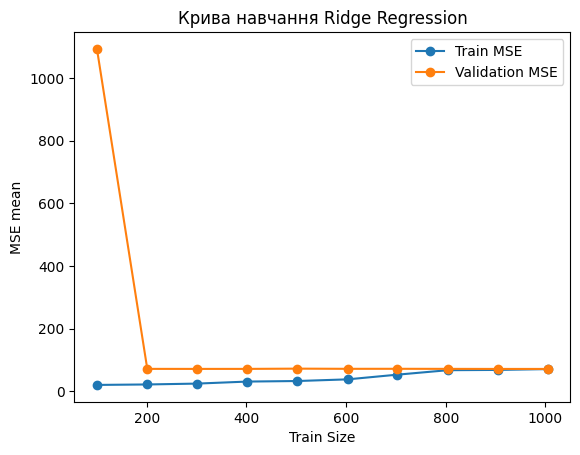

In [12]:
X_scaled = scaler.fit_transform(X)
ridge = Ridge(alpha=grid.best_params_["alpha"])  

train_sizes, train_scores, val_scores = learning_curve(
    ridge,
    X_scaled,
    y,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -train_scores.mean(axis=1)
val_mean = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Train MSE")
plt.plot(train_sizes, val_mean, 'o-', label="Validation MSE")
plt.title("Крива навчання Ridge Regression")
plt.xlabel("Train Size")
plt.ylabel("MSE mean")
plt.legend()
plt.show()


На малій кількості (10%) прикладів у навчальному наборі бачимо велику різницю між значеннями RMSE: на тестовому > 1000, а на навчальному близько нуля, тобто модель перенавчена. При збільшенні розміру навчальної вибірки помилка зростає на навчальній множині і знижується на тестовій, модель краще узагальнює закономірності. 